## A model for brain cancer detection

### AI in healthcare

Integrating AI into healthcare holds excellent potential for improving disease diagnosis, treatment selection, and clinical laboratory testing. AI tools can leverage large datasets and identify patterns to surpass human performance in several healthcare aspects. AI offers increased accuracy, reduced costs, and time savings while minimizing human errors. It can revolutionize personalized medicine, optimize medication dosages, enhance population health management, establish guidelines, provide virtual health assistants, support mental health care, improve patient education, and influence patient-physician trust.

![](https://assets.delveinsight.com/blog/wp-content/uploads/2022/02/09180614/Applications-of-AI-in-Healthcare.jpg)

#### The goal of this project is to build a model that will determine the type of brain cancer based on mrt scans of the brain

[the data is from Kaggle](https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c)

In [6]:
import numpy as np 
import pandas as pd 
import os
import glob

In [15]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.preprocessing import image


#### Getting image paths with pathlib

In [16]:
dataset_dir = pathlib.Path('archive 44')

#### Uplouding and preparing data for training, validation, testing

In [17]:
full_ds = tf.keras.utils.image_dataset_from_directory( #uploading img from subdirectories(classes)
    dataset_dir,
    seed=123,
    image_size=(128, 128),
    batch_size=32) #Number of samples per iteration

total_size = len(full_ds)
train_size = int(0.7 * total_size)

if (total_size - train_size) % 2 == 0:
    val_size = int(0.15 * total_size)
    test_size = int(0.15 * total_size)
else:
    val_size = (total_size - train_size - 1) / 2 + 1
    test_size = (total_size - train_size - 1) / 2
    

train_ds = full_ds.take(train_size) # splitting images to 70-15-15
test_ds = full_ds.skip(train_size).take(test_size)
val_ds = full_ds.skip(train_size + test_size)

print(f"Train size: {train_ds.cardinality().numpy()}")
print(f"Test size: {test_ds.cardinality().numpy()}")
print(f"Validation size: {val_ds.cardinality().numpy()}")


Found 4478 files belonging to 44 classes.
Train size: 98
Test size: 21
Validation size: 21


#### Number of classes (types of brain tumor) and their names

In [18]:
all_labels = []

for images, labels in train_ds:
    all_labels.extend(labels.numpy())

# count of unique labels in train_ds
unique_labels = set(all_labels)
num_classes = len(unique_labels)

print(f'Number of classes in train_ds: {num_classes}')

class_names = full_ds.class_names
print(f'Class names: {class_names}')

Number of classes in train_ds: 44
Class names: ['Astrocitoma T1', 'Astrocitoma T1C+', 'Astrocitoma T2', 'Carcinoma T1', 'Carcinoma T1C+', 'Carcinoma T2', 'Ependimoma T1', 'Ependimoma T1C+', 'Ependimoma T2', 'Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Germinoma T1C+', 'Germinoma T2', 'Glioblastoma T1', 'Glioblastoma T1C+', 'Glioblastoma T2', 'Granuloma T1', 'Granuloma T1C+', 'Granuloma T2', 'Meduloblastoma T1', 'Meduloblastoma T1C+', 'Meduloblastoma T2', 'Meningioma T1', 'Meningioma T1C+', 'Meningioma T2', 'Neurocitoma T1', 'Neurocitoma T1C+', 'Neurocitoma T2', 'Oligodendroglioma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Papiloma T1', 'Papiloma T1C+', 'Papiloma T2', 'Schwannoma T1', 'Schwannoma T1C+', 'Schwannoma T2', 'Tuberculoma T1', 'Tuberculoma T1C+', 'Tuberculoma T2', '_NORMAL T1', '_NORMAL T2']


In [19]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print(class_counts)

{'Astrocitoma T1': 176, 'Astrocitoma T1C+': 233, 'Astrocitoma T2': 171, 'Carcinoma T1': 66, 'Carcinoma T1C+': 112, 'Carcinoma T2': 73, 'Ependimoma T1': 45, 'Ependimoma T1C+': 48, 'Ependimoma T2': 57, 'Ganglioglioma T1': 20, 'Ganglioglioma T1C+': 18, 'Ganglioglioma T2': 23, 'Germinoma T1': 27, 'Germinoma T1C+': 40, 'Germinoma T2': 33, 'Glioblastoma T1': 55, 'Glioblastoma T1C+': 94, 'Glioblastoma T2': 55, 'Granuloma T1': 30, 'Granuloma T1C+': 31, 'Granuloma T2': 17, 'Meduloblastoma T1': 23, 'Meduloblastoma T1C+': 67, 'Meduloblastoma T2': 41, 'Meningioma T1': 272, 'Meningioma T1C+': 369, 'Meningioma T2': 233, 'Neurocitoma T1': 130, 'Neurocitoma T1C+': 223, 'Neurocitoma T2': 104, 'Oligodendroglioma T1': 86, 'Oligodendroglioma T1C+': 72, 'Oligodendroglioma T2': 66, 'Papiloma T1': 66, 'Papiloma T1C+': 108, 'Papiloma T2': 63, 'Schwannoma T1': 148, 'Schwannoma T1C+': 194, 'Schwannoma T2': 123, 'Tuberculoma T1': 28, 'Tuberculoma T1C+': 84, 'Tuberculoma T2': 33, '_NORMAL T1': 251, '_NORMAL T2': 

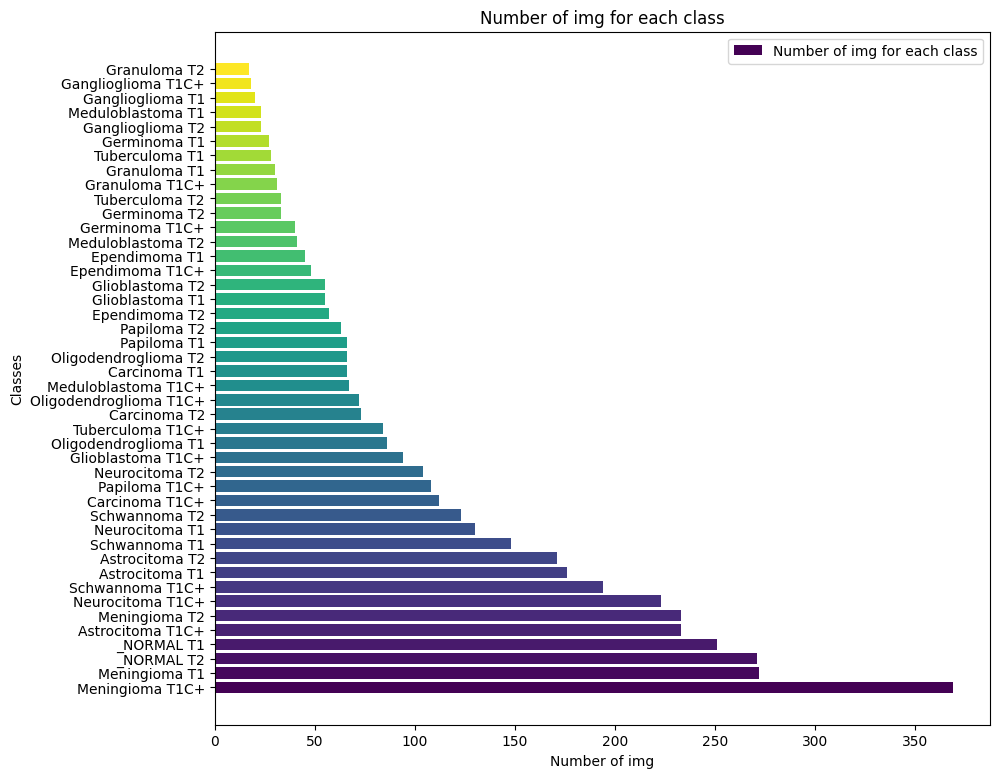

In [20]:
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Separation by class names and number of classes
classes, counts = zip(*sorted_classes)

# Colors for each column
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))

plt.figure(figsize=(10, 9))

# Create a horizontal bar chart
plt.barh(classes, counts, color=colors, label = 'Number of img for each class')

plt.xlabel('Number of img')
plt.ylabel('Classes')
plt.title('Number of img for each class')
plt.legend()
plt.show()

#### Randomly selected images of brain with or without tumor

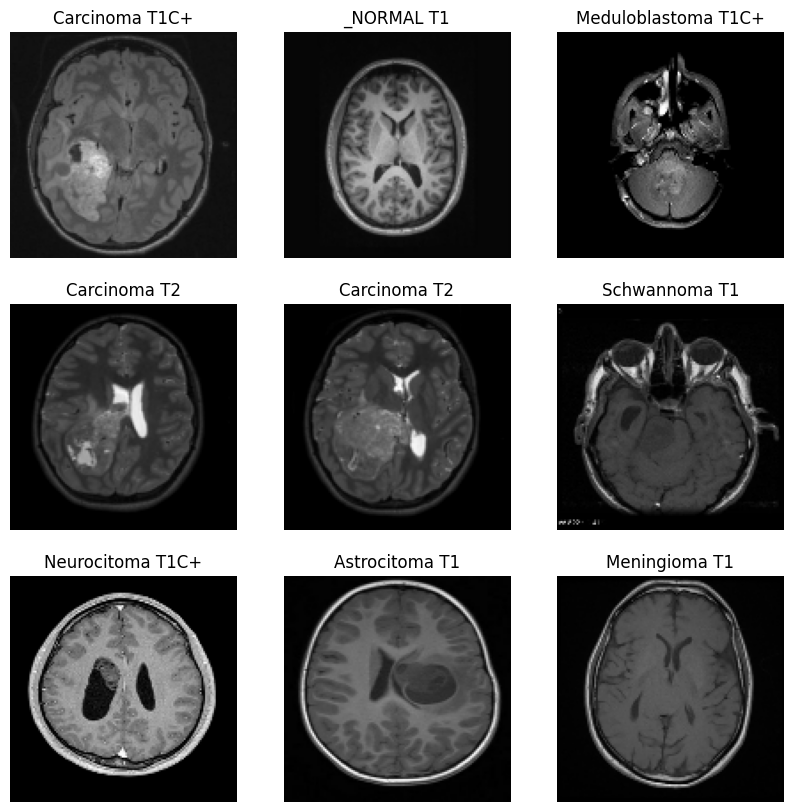

In [21]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
AUTOTUNE = tf.data.AUTOTUNE #optimizes data loading

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #Caches data, mixes, increases image processing speed
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) #Caches validation data and optimizes its loading for faster access.
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Creating a model

In [23]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(128, 128, 3)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(), #normilizing 
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Dropout(0.5), #preventing owerlearning
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax') #last layer returns probabilities
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)      

#### Training model

Epoch 1/20


98/98 [==============================] - 19s 156ms/step - loss: 3.4920 - accuracy: 0.1923 - val_loss: 14.1237 - val_accuracy: 0.0164
Epoch 2/20
98/98 [==============================] - 12s 121ms/step - loss: 2.1356 - accuracy: 0.4397 - val_loss: 12.3753 - val_accuracy: 0.0701
Epoch 3/20
98/98 [==============================] - 12s 122ms/step - loss: 1.6426 - accuracy: 0.5364 - val_loss: 15.2439 - val_accuracy: 0.0254
Epoch 4/20
98/98 [==============================] - 12s 120ms/step - loss: 1.1799 - accuracy: 0.6540 - val_loss: 11.6030 - val_accuracy: 0.1075
Epoch 5/20
98/98 [==============================] - 12s 121ms/step - loss: 0.8752 - accuracy: 0.7401 - val_loss: 3.4975 - val_accuracy: 0.3806
Epoch 6/20
98/98 [==============================] - 12s 120ms/step - loss: 0.6576 - accuracy: 0.8029 - val_loss: 2.6092 - val_accuracy: 0.4612
Epoch 7/20
98/98 [==============================] - 12s 121ms/step - loss: 0.4353 - accuracy: 0.8622 - val_loss: 1.0063 - val_accuracy: 

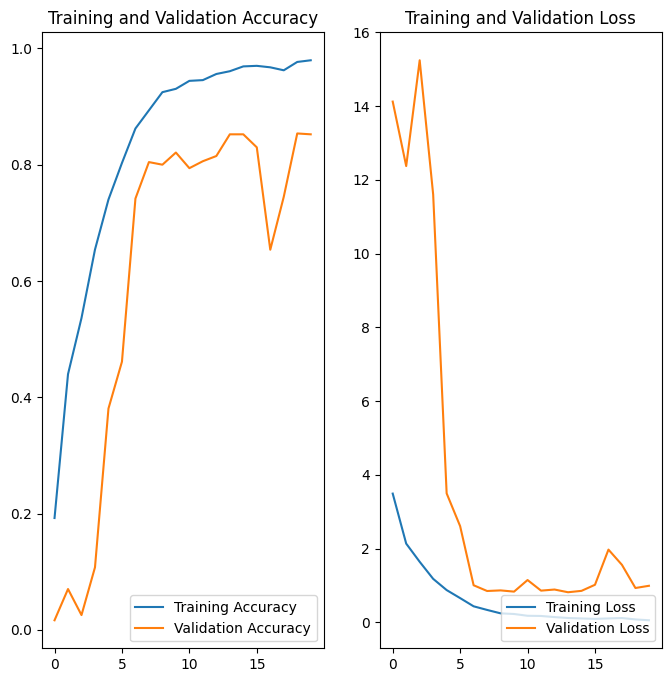

In [24]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

#### Checking accuracy on testing data

Accuracy is 86%, which is good result

In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Accuracy on test data: {test_accuracy}")

21/21 [==============================] - 4s 53ms/step - loss: 0.8570 - accuracy: 0.8646
Accuracy on test data: 0.8645833134651184


#### Saving model

In [26]:
model.save_weights('model_brain_tumor_1')
model.load_weights('model_brain_tumor_1')

#### Verification of model performance

In [33]:
img_path = 'meningomaa.png'
img = image.load_img(img_path, target_size=(128, 128))  # Size as model has
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # adding batch 
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {class_names[predicted_class]}")

1/1 [==============================] - 0s 56ms/step
Predicted class: Meningioma T1C+


In [36]:
img_path = 'papilpma.png'
img = image.load_img(img_path, target_size=(128, 128)) 
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
predictions1 = model.predict(img_array)
predicted_class1 = np.argmax(predictions1[0])
print(f"Predicted class: {class_names[predicted_class1]}")

1/1 [==============================] - 0s 58ms/step
Predicted class: Papiloma T1C+


In [37]:
img_path = 'schwannoma.png'
img = image.load_img(img_path, target_size=(128, 128))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f"Predicted class: {class_names[predicted_class]}")

1/1 [==============================] - 0s 56ms/step
Predicted class: Schwannoma T1C+
